# Long Run Portfolio Choice

This notebook summarizes how the distribution of returns is affected by the investment horizon.

## Load Packages and Extra Functions

In [1]:
using Dates, Distributions

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printTable2

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Long-Run Returns as a Sum of Short-Run Returns

Let $R_{t}$ be a one-period net return. 
It is sometimes convenient to approximate the $q$-period return $Z_{q}$ as

$
Z_{q}    =(R_{1}+1)(R_{2}+1)\ldots(R_{q}+1)-1
$

This is sometimes approximated by 

$
Z_{q}   \approx R_{1}+R_{2}+\ldots+R_{q}. 
$

However, log returns $r=\ln (1+R)$ are better suited for multi-period analysis since there is no approximation error in

$z_{q}=r_{1}+r_{2}+\ldots+r_{q}$

In [3]:
R_A = [5;-5;5]/100               #net returns portfolio A in three periods
R_B = [20;-35;25]/100

r_A = log.(1.0.+R_A)             #log returns
r_B = log.(1.0.+R_B)

Price_A = [1;cumprod(1.0.+R_A)]     #price of portfolio A, assuming price in t=0 is 1.0
Price_B = [1;cumprod(1.0.+R_B)]

TotRet_A = Price_A[end]/Price_A[1] - 1
TotRet_B = Price_B[end]/Price_B[1] - 1

printblue("Prices:")
printTable([Price_A Price_B],["asset A","asset B"],string.(0:3),cell00="period")

printblue("Total net returns: A and B, in %")
printmat([TotRet_A TotRet_B]*100)

printblue("Average net returns: A and B, in %")
printmat(mean([R_A R_B],dims=1)*100)

printblue("Average log returns: A and B, in %")
printmat(mean([r_A r_B],dims=1)*100)

Prices:
period   asset A   asset B
0          1.000     1.000
1          1.050     1.200
2          0.997     0.780
3          1.047     0.975

Total net returns: A and B, in %
     4.737    -2.500

Average net returns: A and B, in %
     1.667     3.333

Average log returns: A and B, in %
     1.543    -0.844



# Distribution of Long-Run Returns in the iid Case

If $r$ is iid N$(\mu,\sigma^2)$, then $z_q$ is N$(q\mu,q\sigma^2)$. 

In [4]:
Φ(x,μ=0,σ²=1) = cdf(Normal(μ,sqrt(σ²)),x)  #lecture notes notation for cdf of N(μ,σ²)
ϕ(x,μ=0,σ²=1) = pdf(Normal(μ,sqrt(σ²)),x)  #pdf of N(μ,σ²)

ϕ (generic function with 3 methods)

## Pdfs of Long-Run Returns (for Different Horizons)

In [5]:
z = range(-50,stop=100,length=101)
μ = 0.06*100
σ = 0.19*100
pdf_z1y  = ϕ.(z,μ,σ^2)              #density functions of returns
pdf_z10y = ϕ.(z,10*μ,10*σ^2);

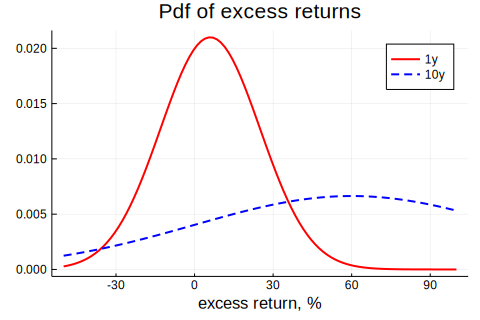

In [6]:
plot( z,[pdf_z1y pdf_z10y],
      linecolor = [:red :blue],
      linestyle = [:solid :dash],
      linewidth = 2,
      label = ["1y" "10y"],
      title = "Pdf of excess returns",
      xlabel = "excess return, %" )

##    Prob(zᵉ < 0) for Different Horizons

In [7]:
t = 1:10

ProbNegReturn = fill(NaN,length(t))
for i in t
    ProbNegReturn[i] = Φ(0,i*μ,i*σ^2)    #cdf(0) for different horizons
end

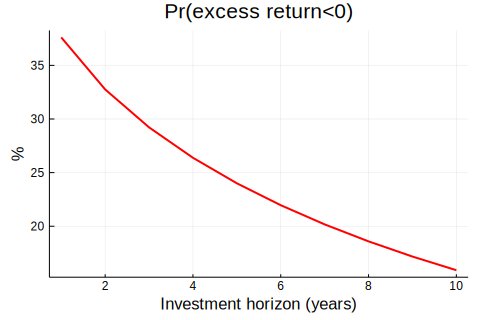

In [8]:
plot( t,ProbNegReturn*100,
      linecolor = :red,
      linewidth = 2,
      legend = false,
      title = "Pr(excess return<0)",
      xlabel = "Investment horizon (years)",
      ylabel = "%" )

## E(zᵉ|zᵉ < 0) for Different Horizons

see lecture notes for details

In [9]:
t = 1:10

CondER = fill(NaN,length(t))
for i in t
    CondER[i] = i*μ - sqrt(i)*σ*ϕ(-sqrt(i)*μ/σ)/Φ(-sqrt(i)*μ/σ)
end

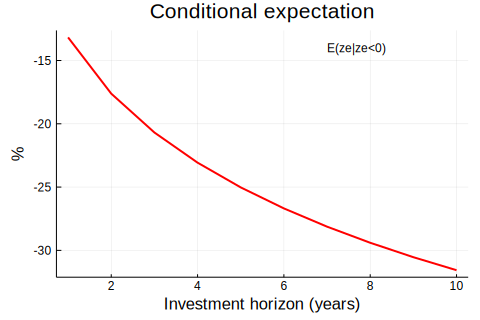

In [10]:
plot( t,CondER,
      linecolor = :red,
      linewidth = 2,
      legend = false,
      title = "Conditional expectation",
      xlabel = "Investment horizon (years)",
      ylabel = "%",
      annotation = (7,-14,text("E(ze|ze<0)",8,:left)) )